In [1]:
import os
os.chdir("../")

import sys
sys.path.insert(1, '../src/')

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

import numpy as np
import os
import cv2

#import csv_parse
import classifier

%load_ext autoreload
%autoreload

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [87]:
def make_dataframes():
    txt_path = "/data/anudeep_home/covidx/"
    image_path = "/data/anudeep_home/covidx/data/"
    train_txt = open(txt_path+'train_split.txt', "r").readlines()
    test_txt = open(txt_path+'test_split.txt', "r").readlines()
    
    test_to_df = []
    for k in test_txt:
        temp = []
        fname = k.split(" ")[1]
        label = k.split(" ")[2]
        test_to_df.append([fname, label])


    train_to_df = []
    for k in train_txt:
        temp = []
        fname = k.split(" ")[1]
        label = k.split(" ")[2]
        train_to_df.append([fname, label])
        
    test_df = pd.DataFrame(test_to_df, columns = ['Path', 'feature_string'])
    train_df = pd.DataFrame(train_to_df, columns = ['Path', 'feature_string'])
    
    return train_df, test_df



full_train_df, full_val_df = make_dataframes()


# Initialize classifier : <image_size> <num_gpus> <num_classes> <batch_size> <experiment_group> <experiment_title>

classifier_covid = classifier.Classifier(320, 0, 3, 48, "multi_class", "densenet121_softmax_cce_320x320_try3_")#
classifier_covid.datagen_init_valid_old(full_train_df, "/data/anudeep_home/covidx/data/train/")

# predict generator setup

test = pd.Series(classifier_covid.validation_generator.labels)
y_labels = test

print(classifier_covid.validation_generator.class_indices)

Found 19212 validated image filenames belonging to 3 classes.
{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [3]:
## Load weights
import os
import glob
from collections import defaultdict
load_path = ''
weight_files = glob.glob("/data/anudeep_home/covid19/model_weights/multi_class/*")#"#preprocess*")
weight_files.sort()

predictions_in_session = defaultdict(list)

curr = weight_files[0]
for ctr, k in enumerate(weight_files):
    if False:#k.split('-')[0] == curr.split('-')[0]:
        continue
    else:
        print(ctr, "\t", weight_files[ctr])
        curr = k 
indx = int(input("please enter your selection"))
load_path = weight_files[indx]

# weighted_bce_224_run3branchfn(cont_e-6)_weights-14.hdf5 - 0.727
# weighted_bce_224_run3branchfn_weights-07.hdf5 - 0.732

0 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_01.hdf5
1 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_02.hdf5
2 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_03.hdf5
3 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_05.hdf5
4 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_06.hdf5
5 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_09.hdf5
6 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_320x320_01.hdf5
7 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_320x320_04.hdf5
8 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_320x320_try2_01.hdf5
9 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet121_softmax_cce_320x320_try2_02.hdf5
10 	 /data/anudeep_home/covid19/model_weights/multi_class/densenet12

In [55]:
classifier_covid.build_model(load_previous_weights=False, freeze_cnn=False)
classifier_covid.model.load_weights(load_path)
print(classifier_covid.model.output)
print('\n\nWeights successfuly loaded\n\n')
classifier_covid.validation_generator.reset()


#np.save("../predictions/"+load_path.split('/')[-1][:-5]+".npy", y_pred_keras)    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256       

[<tf.Tensor 'dense_7/Softmax:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'batch_normalization_3/batchnorm/add_1:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'relu/Relu_1:0' shape=(None, 10, 10, 1024) dtype=float32>]


Weights successfuly loaded




In [56]:
y_pred_keras, embeddings, weight_map = classifier_covid.model.predict_generator(classifier_covid.validation_generator,verbose = 1,steps=classifier_covid.validation_generator.n/classifier_covid.validation_generator.batch_size)

10/9 [==============================] - 32s 3s/step


In [57]:
y_pred_keras.shape, embeddings.shape, weight_map.shape

((474, 3), (474, 512), (474, 10, 10, 1024))

In [88]:
embeddings = np.load("multi_class_embeddings.npy")

# PCA and T-SNE

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


tsne = TSNE(random_state=0, verbose=1)
tsne_results = tsne.fit_transform(embeddings)

tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19212 samples in 0.005s...
[t-SNE] Computed neighbors for 19212 samples in 6.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19212
[t-SNE] Computed conditional probabilities for sample 2000 / 19212
[t-SNE] Computed conditional probabilities for sample 3000 / 19212
[t-SNE] Computed conditional probabilities for sample 4000 / 19212
[t-SNE] Computed conditional probabilities for sample 5000 / 19212
[t-SNE] Computed conditional probabilities for sample 6000 / 19212
[t-SNE] Computed conditional probabilities for sample 7000 / 19212
[t-SNE] Computed conditional probabilities for sample 8000 / 19212
[t-SNE] Computed conditional probabilities for sample 9000 / 19212
[t-SNE] Computed conditional probabilities for sample 10000 / 19212
[t-SNE] Computed conditional probabilities for sample 11000 / 19212
[t-SNE] Computed conditional probabilities for sample 12000 / 19212
[t-SNE] Computed conditional probabilities for sam

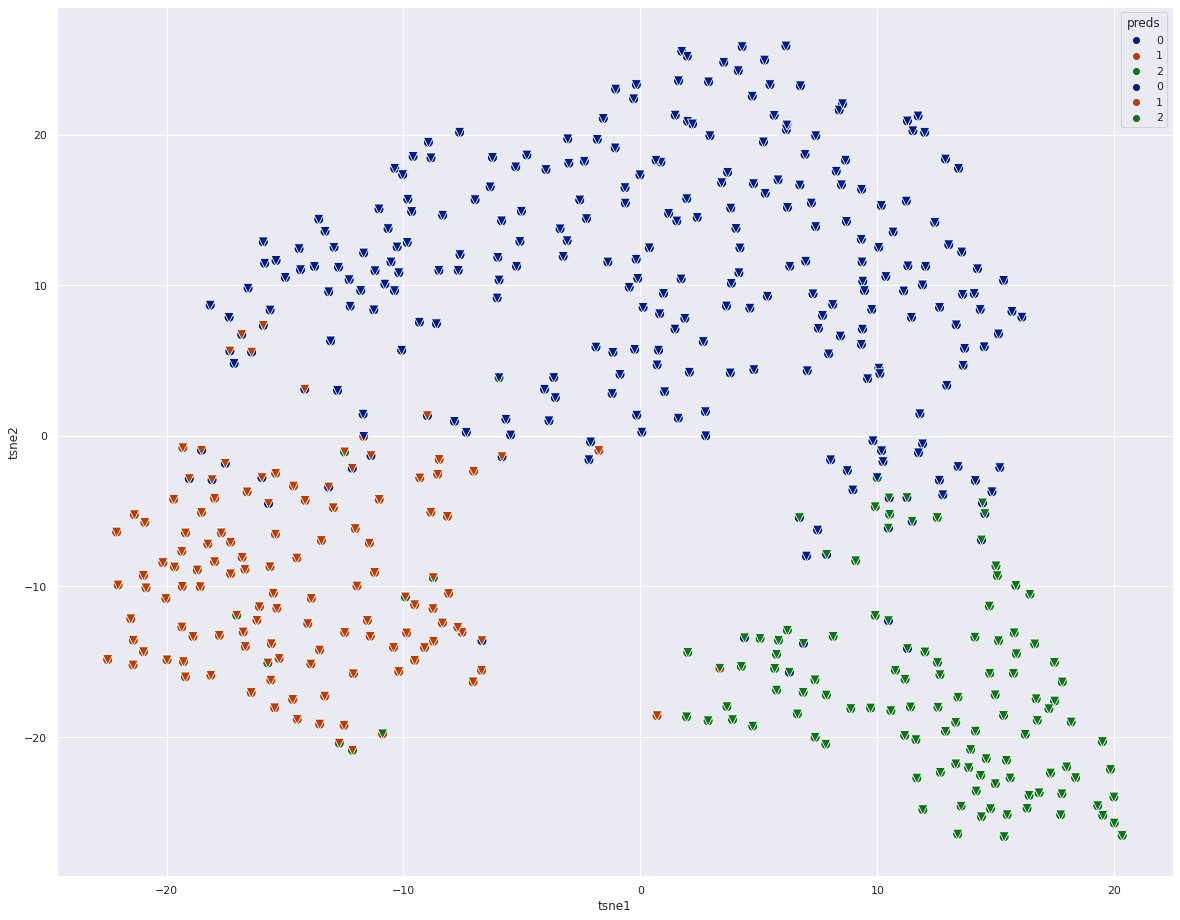

In [85]:
seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_results, x='tsne1', y='tsne2', hue='label', palette="dark", s=100)

seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_results, x='tsne1', y='tsne2', hue='preds', marker = 'v', palette="dark", s=100)

plt.show()

In [31]:
import seaborn

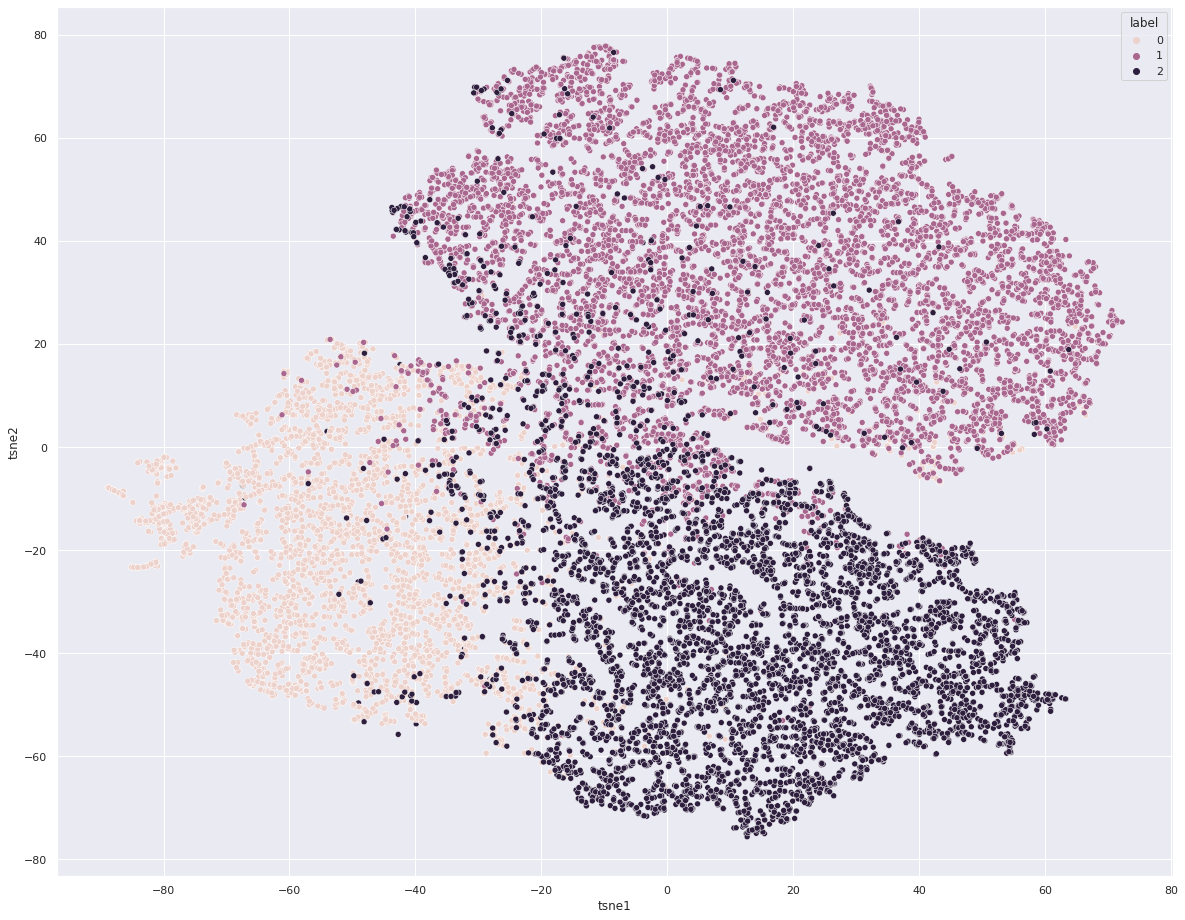

In [91]:
seaborn.set(rc={'figure.figsize':(20, 16)})
seaborn.scatterplot(data=tsne_results, x='tsne1', y='tsne2', hue='label')

plt.show()

# Identify hard cases for each label

In [95]:
tsne_covid = tsne_results[tsne_results["label"] == 0]
tsne_normal = tsne_results[tsne_results["label"] == 1]
tsne_pneu = tsne_results[tsne_results["label"] == 2]

<ipython-input-171-623702f36548>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['two_sigma'] = two_sigma


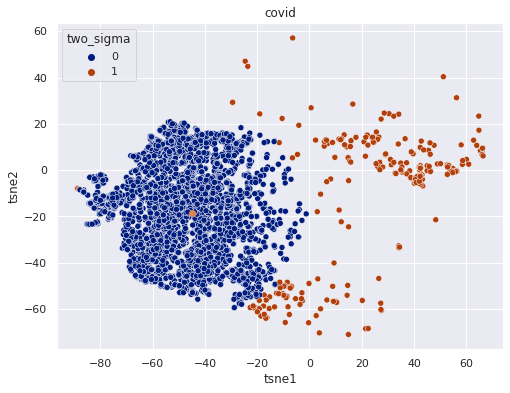

<ipython-input-171-623702f36548>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['two_sigma'] = two_sigma


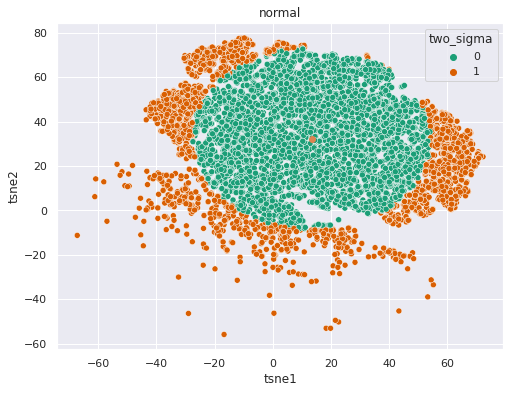

<ipython-input-171-623702f36548>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['two_sigma'] = two_sigma


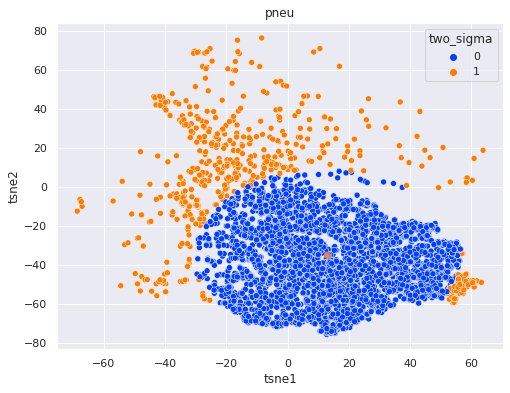

In [171]:
names = ["covid", "normal", "pneu"]
palettes = ["dark", "Dark2", "bright"]
for ctr, df in enumerate([tsne_covid, tsne_normal, tsne_pneu]):
    # seaborn.set(rc={'figure.figsize':(8, 6)})
    # seaborn.scatterplot(data=tsne_covid, x='tsne1', y='tsne2').set_title("covid")
    center = (sum(df['tsne1'])/len(df['tsne1']), sum(df['tsne2'])/len(df['tsne2']))
    # plt.scatter(x=sum(tsne_covid['tsne1'])/len(tsne_covid['tsne1']), y=sum(tsne_covid['tsne2'])/len(tsne_covid['tsne2']))

    # plt.show()


    dist_to_center = []

    for index, row in df.iterrows():
        dist_to_center.append(((center[0] - row['tsne1'])**2 +(center[1] - row['tsne2'])**2)**(1/2))
    dist_to_center = np.array(dist_to_center) 
    
    if ctr == 1:
        desired_dist = 3.0*np.std(dist_to_center)
    else:
        desired_dist = 2.8*np.std(dist_to_center)
    count = 0
    two_sigma = []
    for k in dist_to_center:
        if k < desired_dist:
            count+=1
            two_sigma.append(0)
        else:
            two_sigma.append(1)
    #print(count, len(dist_to_center), count/len(dist_to_center), len(two_sigma))

    df['two_sigma'] = two_sigma

    seaborn.set(rc={'figure.figsize':(8, 6)})
    seaborn.scatterplot(data=df, x='tsne1', y='tsne2', hue="two_sigma", palette=palettes[ctr]).set_title(names[ctr])
    plt.scatter(x=sum(df['tsne1'])/len(df['tsne1']), y=sum(df['tsne2'])/len(df['tsne2']))

    plt.show()


In [189]:
tsne_covid_outlier = list(tsne_covid[tsne_covid['two_sigma'] == 1].index)
tsne_pneu_outlier = list(tsne_pneu[tsne_pneu['two_sigma'] == 1].index)
tsne_normal_outlier = list(tsne_normal[tsne_normal['two_sigma'] == 1].index)

tsne_covid_nonoutlier = list(tsne_covid[tsne_covid['two_sigma'] == 0].index)
tsne_pneu_nonoutlier = list(tsne_pneu[tsne_pneu['two_sigma'] == 0].index)
tsne_normal_nonoutlier = list(tsne_normal[tsne_normal['two_sigma'] == 0].index)

In [194]:
outliers_all =  tsne_covid_outlier + tsne_pneu_outlier + tsne_normal_outlier

In [196]:
np.save("outliers_index.npy", np.array(outliers_all))

In [174]:
tsne_normal_outlier.index

Int64Index([ 4557,  4559,  4560,  4561,  4562,  4569,  4570,  4576,  4578,
             4579,
            ...
            13278, 13283, 13285, 13287, 13289, 13291, 13292, 13294, 13297,
            13298],
           dtype='int64', length=2639)

In [175]:
tsne_covid_outlier.index

Int64Index([  41,   42,   43,   46,   60,   62,   63,   71,   91,  103,
            ...
            4351, 4357, 4361, 4362, 4363, 4366, 4370, 4372, 4376, 4384],
           dtype='int64', length=258)

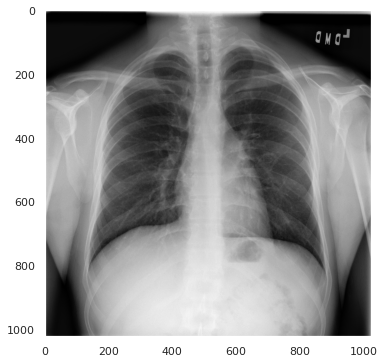

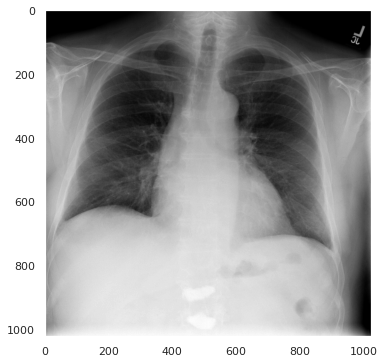

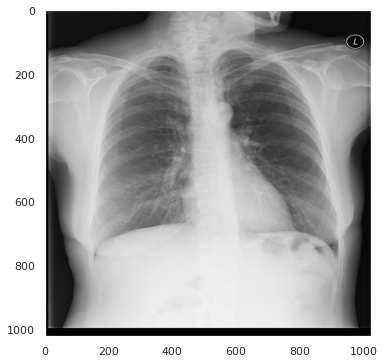

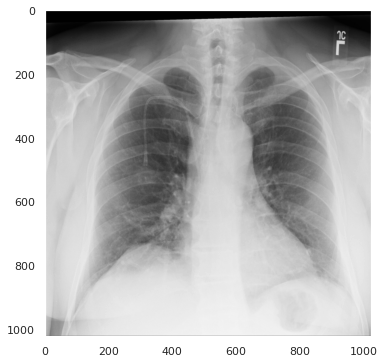

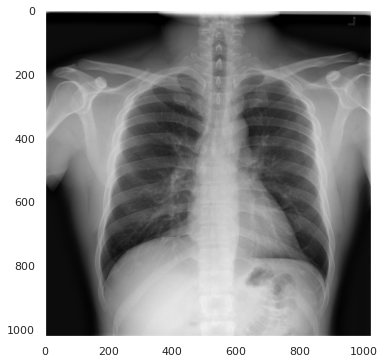

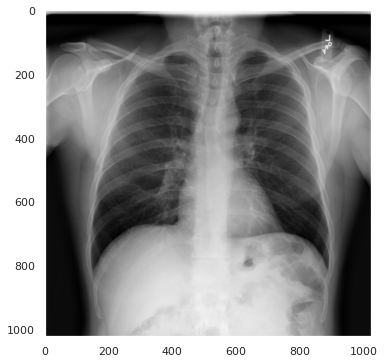

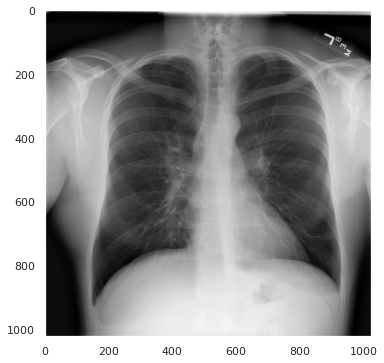

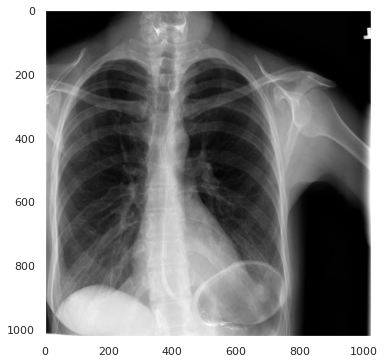

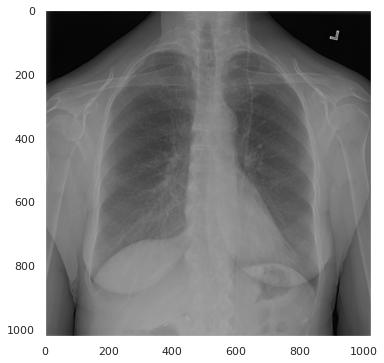

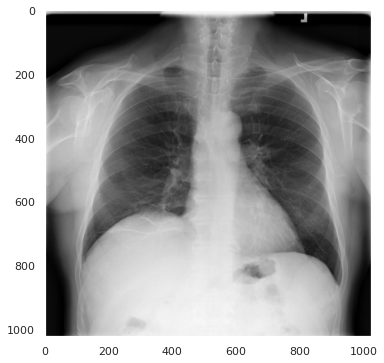

In [193]:
# select outlier
seaborn.set_style("dark")
outliers = tsne_normal_nonoutlier

for k in outliers[0:10]:
    path = full_train_df.iloc[k]['Path']
    a = plt.imread("/data/anudeep_home/covidx/data/train/"+path)
    plt.imshow(a, cmap="gray")
    plt.show()